# The Transformer Architecture



In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

Positionwise Feed-Forward Networks

In [2]:
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

The innermost dimension
of a tensor changes

In [3]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

/home/d2l-worker/miniconda3/envs/d2l-en-release-0/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[ 0.2089,  0.1863,  0.8114,  0.5922, -0.2237,  0.3001,  0.2044, -0.5325],
        [ 0.2089,  0.1863,  0.8114,  0.5922, -0.2237,  0.3001,  0.2044, -0.5325],
        [ 0.2089,  0.1863,  0.8114,  0.5922, -0.2237,  0.3001,  0.2044, -0.5325]],
       grad_fn=<SelectBackward0>)

Compares the normalization across different dimensions
by layer normalization and batch normalization

In [4]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


Using a residual connection followed by layer normalization

In [5]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

The output tensor also has the same shape after the addition operation

In [6]:
add_norm = AddNorm(4, 0.5)
d2l.check_shape(add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))), (2, 3, 4))

A single layer within the encoder

In [7]:
class TransformerEncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

Any layer in the transformer encoder
does not change the shape of its input

In [8]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

Transformer encoder

In [9]:
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

Create a two-layer transformer encoder

In [10]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
d2l.check_shape(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens),
                (2, 100, 24))

The transformer decoder
is composed of multiple identical layers

In [11]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

The feature dimension (`num_hiddens`) of the decoder is
the same as that of the encoder

In [12]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state)[0], X.shape)

Construct the entire transformer decoder

In [13]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

Training

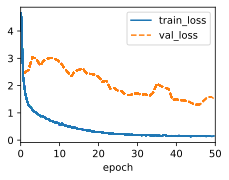

In [14]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

Translate a few English sentences

In [15]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Visualize the transformer attention weights

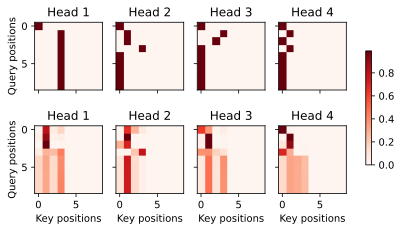

In [17]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0).reshape((num_blks, num_heads,
    -1, data.num_steps))
d2l.check_shape(enc_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

To visualize both the decoder self-attention weights and the encoder-decoder attention weights,
we need more data manipulations

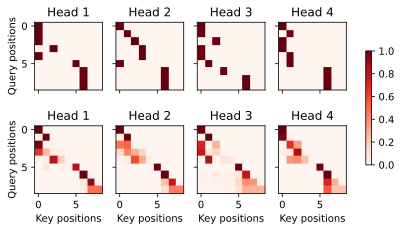

In [20]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_blks, num_heads, data.
    num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

d2l.check_shape(dec_self_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
d2l.check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

No query from the output sequence
attends to those padding tokens from the input sequence

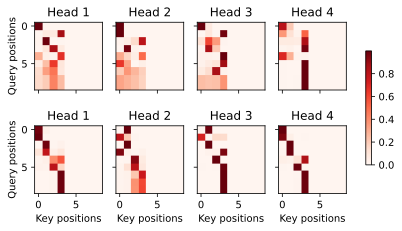

In [21]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))